## Apple Tweet - Sentiment Analysis using LSTM


In this project, we plan to look into the sentiment around the Apple computers on tweets, containing #AAPL, @apple, etc.

Tweets can be positive, neutral or negative.

The task is to identify whether the tweet about Apple is positive, neutral or negative. If the tweet isn't about Apple, identification should be neutral.

Sentiment are represented as follows:
* Positive - 5
* Neutral - 3
* Negative - 1

#### Import Libraries

In [273]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#format columns so comments don't get cut off
pd.set_option('display.max_columns', None) 

#### Read input data

In [274]:
df = pd.read_csv("Apple-Twitter-Sentiment-DFE.csv", encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [275]:
#Size of dataset
df.shape

(3886, 12)

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [277]:
#Consider only the sentiment and text column for our analysis
apple_tweet = df[['sentiment','text']].copy()
#apple_tweet = df.copy()
apple_tweet.head()

,sentiment,text
0,3,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,My cat only chews @apple cords. Such an #Apple...
3,3,I agree with @jimcramer that the #IndividualIn...
4,3,Nobody expects the Spanish Inquisition #AAPL


In [278]:
# Adding an extra column to calculate review length
#apple_tweet['Text_length'] = apple_tweet['text'].apply(len)
#apple_tweet.head()

In [279]:
apple_tweet['sentiment'].value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [280]:
#Drop rows that contain "not relevant" in Sentiment column
apple_tweet = apple_tweet[apple_tweet.sentiment != 'not_relevant']

In [281]:
apple_tweet['sentiment'].value_counts()

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

In [282]:
len(apple_tweet)

3804

In [283]:
apple_tweet

,sentiment,text
0,3,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,My cat only chews @apple cords. Such an #Apple...
3,3,I agree with @jimcramer that the #IndividualIn...
4,3,Nobody expects the Spanish Inquisition #AAPL
...,...,...
3881,3,(Via FC) Apple Is Warming Up To Social Media -...
3882,3,RT @MMLXIV: there is no avocado emoji may I as...
3883,5,@marcbulandr I could not agree more. Between @...
3884,1,My iPhone 5's photos are no longer downloading...


<AxesSubplot:xlabel='sentiment', ylabel='count'>

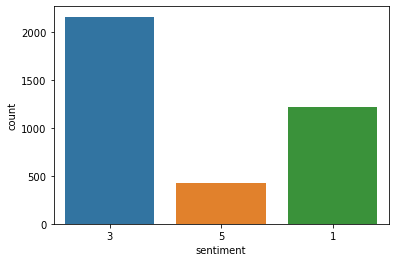

In [284]:
sns.countplot(apple_tweet['sentiment'])

There are only very few positive tweets compared to negative . Most of the tweets are neutral.

In [285]:
#Check for null values
apple_tweet.isnull().sum()

sentiment    0
text         0
dtype: int64

#### Generating a Word Cloud of Reviews

Let's look at a Wordcloud of our data to see what words are most frequently showing up!

In [167]:
#!pip install wordcloud
from wordcloud import WordCloud

(-0.5, 1599.5, 1199.5, -0.5)

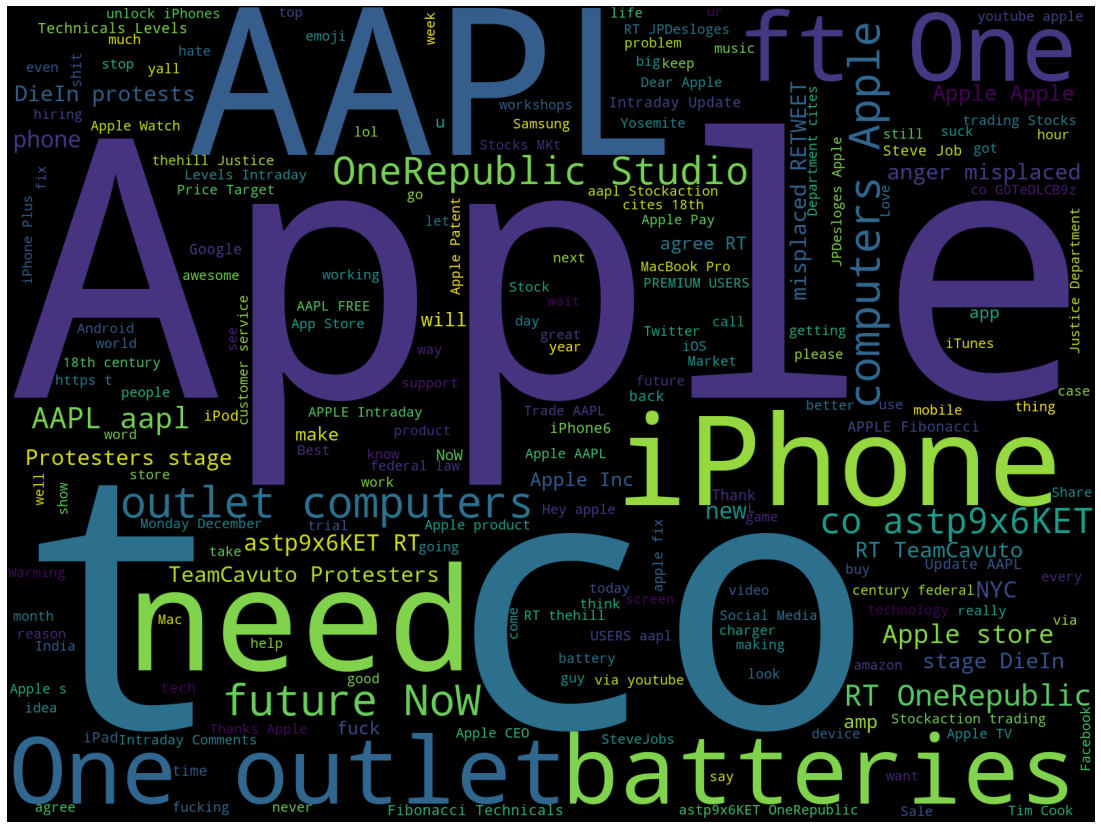

In [168]:
cloud = WordCloud(width=1600, height=1200).generate(" ".join(apple_tweet['text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

#### Text Preprocessing

In [252]:
def remove_chars():
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]')
    for i in range(len(apple_tweet["text"])):
        print(apple_tweet['text'][i])
        apple_tweet['text'][i] = pattern.sub('', apple_tweet['text'][i])
        
remove_chars()

apple_tweet.head()

The  best Steve Jobs emails ever
RT  Why AAPL Stock Had a MiniFlash Crash Today AAPL 

My cat only chews  cords Such an 
I agree with  that the  should own not trade   its extended so todays pullback is good to see
Nobody expects the Spanish Inquisition 
 Rocket Stocks to Buy for December Gains Apple and More
Top  all   Damn right 
CNBCTV s margins better than expected  
Apple Inc Flash Crash What You Need to Know  
This Presentation Shows What Makes The Worlds Biggest Tech Companies 
WTF MY BATTERY WAS  ONE SECOND AGO AND NOW IS  WTF IS THIS 
Apple Watch Tops Search Engine List of Best Wearable Tech    
The BestDesigned   In the World According to   
RT  Bought my  at the  storepretty good logo match  cant wait to install it 
 Contact sync between Yosemite and iOS is seriously screwed up It used to be much more stable in the past  
  Thanks to the non factual dumb Twitter followers stock drops  points in one minute Thanks dummies 
WARNING IF YOU BUY AN IPHONE S UNLOCKED FROM  IPHONE Y

KeyError: 17

In [286]:
# Lemmatize words, and remove stop words and punctuation
lemmatizer = WordNetLemmatizer()

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove URLs, words starting with $,#,@
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Return the cleaned text as a list of lemmatized words
    '''
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]', '', text, flags=re.MULTILINE)

    
    text = ''.join([t for t in text if t not in string.punctuation])
    
    text = ''.join([t for t in text if not t.isdigit()])
    
    return [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stopwords.words('english')]



apple_tweet['text_cleaned'] = apple_tweet['text'].apply(lambda x: text_process(x))

In [287]:
apple_tweet

,sentiment,text,text_cleaned
0,3,#AAPL:The 10 best Steve Jobs emails ever...htt...,"[best, Steve, Jobs, email, ever]"
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,"[RT, AAPL, Stock, MiniFlash, Crash, Today, AAPL]"
2,3,My cat only chews @apple cords. Such an #Apple...,"[cat, chew, cord]"
3,3,I agree with @jimcramer that the #IndividualIn...,"[agree, trade, extended, today, pullback, good..."
4,3,Nobody expects the Spanish Inquisition #AAPL,"[Nobody, expects, Spanish, Inquisition]"
...,...,...,...
3881,3,(Via FC) Apple Is Warming Up To Social Media -...,"[Via, FC, Apple, Warming, Social, Media, Apple..."
3882,3,RT @MMLXIV: there is no avocado emoji may I as...,"[RT, avocado, emoji, may, ask]"
3883,5,@marcbulandr I could not agree more. Between @...,"[could, agree, great, thing, happen]"
3884,1,My iPhone 5's photos are no longer downloading...,"[iPhone, photo, longer, downloading, automatic..."


### Model Generation 

In [289]:
# Split data into training and test sets
y = pd.get_dummies(apple_tweet['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(apple_tweet,y,
                                                    #apple_tweet['sentiment'],
                                                    test_size=0.2,
                                                    stratify = y )

In [290]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [291]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text_cleaned'])

In [292]:
vocab_size = len(tokenizer.index_word)+1
print("Vocabulary Size: ",vocab_size)
print(tokenizer.document_count)

print(tokenizer.index_word)

Vocabulary Size:  4397
3043
{1: 'rt', 2: 'apple', 3: 'need', 4: 'one', 5: 'computer', 6: 'battery', 7: 'aapl', 8: 'future', 9: 'studio', 10: 'ft', 11: 'outlet', 12: 'store', 13: 'iphone', 14: 'new', 15: 'phone', 16: 'get', 17: 'agree', 18: 'protest', 19: 'stage', 20: 'misplaced', 21: 'nyc', 22: 'anger', 23: 'protesters', 24: 'retweet', 25: 'via', 26: 'update', 27: 'inc', 28: 'fuck', 29: 'amp', 30: 'make', 31: 'like', 32: 'intraday', 33: 'u', 34: 'app', 35: 'dont', 36: 'shit', 37: 'steve', 38: 'im', 39: 'fix', 40: 'time', 41: 'apples', 42: 'jobs', 43: 'ipad', 44: 'cook', 45: 'thanks', 46: 'ios', 47: 'fibonacci', 48: 'technicals', 49: 'levels', 50: 'could', 51: 'cant', 52: 'free', 53: 'year', 54: 'product', 55: 'watch', 56: 'best', 57: 'please', 58: 'plus', 59: 'macbook', 60: 'great', 61: 'stock', 62: 'back', 63: 'use', 64: 'love', 65: 'even', 66: 'hey', 67: 'work', 68: 'social', 69: 'iphones', 70: 'pay', 71: 'good', 72: 'want', 73: 'ipod', 74: 'music', 75: 'much', 76: 'emoji', 77: 'char

In [293]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train['text_cleaned'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text_cleaned'])

In [294]:
# What do these sequences look like?
X_train_seq[0]

[799, 2, 800, 282, 1372, 2069, 563, 564, 96, 801, 118, 177, 352]


Since we are going to build a sequence model, we should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we use pad_sequence to ensure that all inputs are of the same length.

In [295]:
# Pad the sequences so each sequence is the same length
maxlen = 100

X_train_seq_padded = pad_sequences(X_train_seq,padding='post', maxlen= maxlen)
X_test_seq_padded = pad_sequences(X_test_seq,padding='post', maxlen=maxlen)

In [296]:
# What do these padded sequences look like?
print(X_train_seq_padded[0])
print(X_train_seq_padded[0].shape)


[ 799    2  800  282 1372 2069  563  564   96  801  118  177  352    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
(100,)


In [297]:
print("Size of X_train: ", X_train_seq_padded.shape)
print("Size of X_test: ", X_test_seq_padded.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (3043, 100)
Size of X_test:  (761, 100)
Size of y_train:  (3043, 3)
Size of y_test:  (761, 3)


In [298]:
X_train_seq_padded[0]

array([ 799,    2,  800,  282, 1372, 2069,  563,  564,   96,  801,  118,
        177,  352,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [299]:
# Import the tools needed from keras 

from keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten
from keras.models import Sequential

In [310]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(vocab_size, 16, input_length=maxlen))
model.add(Bidirectional(LSTM(256, dropout = 0.2)))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 16)           70352     
                                                                 
 bidirectional_6 (Bidirectio  (None, 512)              559104    
 nal)                                                            
                                                                 
 dense_29 (Dense)            (None, 128)               65664     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dense_31 (Dense)            (None, 3)                 99        
                                                     

In [311]:
# simple early stopping
es = EarlyStopping(monitor='val_acc', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [312]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test),
                    verbose=1
                   # callbacks=[es]
                   )

Epoch 1/10
96/96 [==============================] - 10s 72ms/step - loss: 0.9275 - acc: 0.5692 - val_loss: 0.8483 - val_acc: 0.6426
Epoch 2/10
96/96 [==============================] - 6s 59ms/step - loss: 0.7027 - acc: 0.7305 - val_loss: 0.6989 - val_acc: 0.7280
Epoch 3/10
96/96 [==============================] - 6s 59ms/step - loss: 0.5358 - acc: 0.7966 - val_loss: 0.6865 - val_acc: 0.7293
Epoch 4/10
96/96 [==============================] - 6s 59ms/step - loss: 0.4221 - acc: 0.8495 - val_loss: 0.7283 - val_acc: 0.7254
Epoch 5/10
96/96 [==============================] - 6s 59ms/step - loss: 0.3205 - acc: 0.8866 - val_loss: 0.8167 - val_acc: 0.7175
Epoch 6/10
96/96 [==============================] - 6s 59ms/step - loss: 0.2593 - acc: 0.9090 - val_loss: 0.8281 - val_acc: 0.7293
Epoch 7/10
96/96 [==============================] - 6s 59ms/step - loss: 0.2118 - acc: 0.9274 - val_loss: 0.9406 - val_acc: 0.7359
Epoch 8/10
96/96 [==============================] - 5s 56ms/step - loss: 0.1793 - 

In [314]:
# Function to plot accuracy and loss of the model

def accuracy_loss_plot(history):
    acc=history.history['acc']
    val_acc = history.history['val_acc']
    
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    accuracy = acc[-1]  # oraccuracy= np.mean(acc) 
    accuracy_percentage = str("{:.3f}".format(accuracy))   

    val_accuracy = val_acc[-1]  # or val_accuracy=np.mean(val_acc) 
    val_accuracy_percentage =  str("{:.3f}".format(val_accuracy))
                                                           
    plt.legend(['Train Accuracy: '+ accuracy_percentage, 'Test Accuracy: '+ val_accuracy_percentage], loc='upper left')
    plt.show()
    
    
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    loss = loss[-1] # np.mean(history['loss'])
    loss_percentage =  str("{:.3f}".format(loss))   
   
    val_loss = val_loss[-1] #np.mean(history['val_loss'])
    val_loss_percentage =  str("{:.3f}".format(val_loss))
    
    plt.legend(['Training Loss: '+loss_percentage, 'Test Loss: '+val_loss_percentage], loc='upper left')
    plt.show()
    

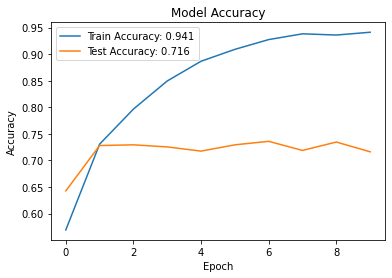

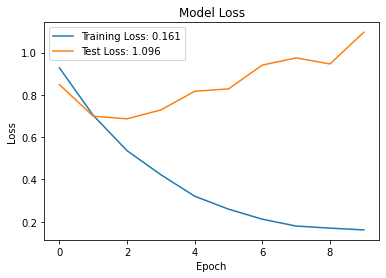

In [315]:
accuracy_loss_plot(history)

With LSTM, the test accuracy is only 72%